# (Damages from) NOAA extreme weather events
The [National Oceanic and Atmospheric Administration](https://en.wikipedia.org/wiki/National_Oceanic_and_Atmospheric_Administration) has a database of extreme weather events that contains lots of detail for every year ([Link](https://www.climate.gov/maps-data/dataset/severe-storms-and-extreme-events-data-table)).  I'll create a workflow that analyzes each year on record and collects information about deaths and damages caused by the extreme weather events.

In [165]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
pd.set_option('display.max_columns', None)  # Unlimited columns

# Custom function for displaying the shape and head of a dataframe
def display(df, n=5):
    print(df.shape)
    return df.head(n)

## Get official list of US counties

In [2]:
import geopandas
# Import a shape file with all the counties in the US.
counties = geopandas.read_file('../data_input/1_USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)

# Set the FIPS code as the index, and sort by it
counties = counties.set_index('FIPS').sort_index(axis=0)
    
# Make a list of the valid FIPS codes
official_counties = counties.index.tolist()

# Samples
random.sample(official_counties, 5)

[39115, 41003, 18051, 40031, 17185]

In [3]:
len(official_counties)

3141

In [4]:
## From the official list of counties, get a dictionary of FIPS state codes

# Extract names and codes
temp1 = counties[['STATE_NAME', 'STATE_FIPS']].copy()
# Turn into dictionary
state_FIPS_codes = temp1.groupby('STATE_NAME').max().to_dict()['STATE_FIPS']

# Samples
random.sample(list(state_FIPS_codes.items()), 5)

[('Rhode Island', 44),
 ('New Hampshire', 33),
 ('Delaware', 10),
 ('South Dakota', 46),
 ('Arizona', 4)]

In [5]:
len(state_FIPS_codes)

51

## Make dictionary of state abbreviations

In [6]:
# Add the full state name to the dafatframe
state_codes = pd.read_csv('../data_input/states_code.csv')
state_codes['state_allcaps'] = state_codes['State'].str.upper()
state_codes = state_codes.set_index('state_allcaps')
state_codes = state_codes.to_dict()['Abbreviation']

# Samples
random.sample(list(state_codes.items()), 5)

[('ALABAMA', 'AL'),
 ('CALIFORNIA', 'CA'),
 ('HAWAII', 'HI'),
 ('PUERTO RICO', 'PR'),
 ('UTAH', 'UT')]

## Make dictionary of weather zones
Many of the FIPS codes in the NOAA dataset correspond not to counties, but to National Weather Service (NWS) Forecast Zones.  Some zones contain several counties, so we want to make sure that each zone-level weather event gets recorded in all the corresponding counties. NWS publishes the zone-county correlations [here](https://www.weather.gov/gis/ZoneCounty).

In [7]:
# Get zone-county correlations
url = 'https://www.weather.gov/source/gis/Shapefiles/County/bp02ap19.dbx'
cols = ['STATE','ZONE','CWA','NAME','STATE_ZONE','COUNTY','FIPS',
        'TIME_ZONE','FE_AREA','LAT','LON']
zones = pd.read_csv(url, delimiter='|', names=cols).sort_values('FIPS')

The column `FIPS` refers to the county FIPS.

In [8]:
print(zones.shape)
zones.head()

(4536, 11)


,STATE,ZONE,CWA,NAME,STATE_ZONE,COUNTY,FIPS,TIME_ZONE,FE_AREA,LAT,LON
165,AL,41,BMX,Autauga,AL041,Autauga,1001,C,c,32.5349,-86.6428
195,AL,266,MOB,Baldwin Coastal,AL266,Baldwin,1003,C,sw,30.4940,-87.6699
191,AL,262,MOB,Baldwin Inland,AL262,Baldwin,1003,C,sw,30.4940,-87.6699
193,AL,264,MOB,Baldwin Central,AL264,Baldwin,1003,C,sw,30.9471,-87.7615
174,AL,50,BMX,Barbour,AL050,Barbour,1005,C,se,31.8696,-85.3932


In [9]:
# Drop any rows corresponding to FIPS codes not on the 
# official list
zones = zones[zones.FIPS.isin(official_counties)]

# Create a dictionary with NWS zones as keys, each 
# corresponding to one or more county FIPS codes.
zone_dict = {}
for row in zones[['FIPS','STATE_ZONE']].iterrows():
    county = row[1]['FIPS']
    zone = row[1]['STATE_ZONE']
    
    if zone not in zone_dict:
        zone_dict[zone] = [county]
    else:
        zone_dict[zone].append(county)
        
# Samples
random.sample(list(zone_dict.items()), 5)

[('PA103', [42091]),
 ('CA067', [6005, 6009, 6017, 6057, 6061, 6109, 6115]),
 ('NY062', [36105]),
 ('VA514', [51570]),
 ('WA035', [53001, 53017, 53025, 53043, 53047])]

In [10]:
len(zone_dict)

3695

# One year of damages
(deaths, injuries, and property damage)

In [149]:
# The full table contains more than I want to use.
df1 = pd.read_csv('../data_local/NOAA/StormEvents_details-ftp_v1.0_d2018_c20190422.csv')

print(df1.shape)
print(df1.columns)
df1.head(2)

(46383, 51)
Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,199901,14,0,199901,15,0,1501526,5683694,MASSACHUSETTS,25,1999,January,Heavy Snow,Z,19,EASTERN PLYMOUTH / ALSO PART OF NORFOLK,BOX,14-JAN-99 00:00:00,EST,15-JAN-99 00:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A strong high pressure system centered over so...,NaN,PDC
1,199901,2,700,199901,2,2359,1500622,5683477,MICHIGAN,26,1999,January,Blizzard,Z,43,OCEANA,GRR,02-JAN-99 07:00:00,EST,02-JAN-99 23:59:00,0,0,0,0,NaN,NaN,NWS STORM SURVEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blizzard conditions developed across lower Mic...,NaN,PDC


In [71]:
# Extract only a few useful columns
df2 = df1[['STATE','STATE_FIPS','CZ_TYPE','CZ_FIPS',
           'DEATHS_DIRECT','DEATHS_INDIRECT','DAMAGE_PROPERTY',
          'INJURIES_DIRECT', 'INJURIES_INDIRECT']].copy()

# Turn nulls into zeros
df2 = df2.fillna(0)

# Cast STATE_FIPS as int, to make sure it gets processed correctly when it's a string
df2['STATE_FIPS'] = df2['STATE_FIPS'].astype(int)

# Add a column with the two-letter state code
df2['state'] = df2['STATE'].map(state_codes)

# Aggregate direct + indirect
df2['deaths'] = df2['DEATHS_DIRECT'] + df2['DEATHS_INDIRECT']
df2['injuries'] = df2['INJURIES_DIRECT'] + df2['INJURIES_INDIRECT']

# Property damages are coded as strings with abbreviations for thousands,
# millions, and billions (why would anyone do that, seriously?). 
# I'll process them into floats.

def process_damages(x):
    if x == 0:
        return 0
    elif len(x) == 1:
        return 0
    elif x[-1] == 'K':
        return float(x[:-1])*1000
    elif x[-1] == 'M':
        return float(x[:-1])*1000000
    elif x[-1] == 'B':
        return float(x[:-1])*1000000000
    else:
        return np.nan

df2['damage'] = df2['DAMAGE_PROPERTY'].apply(process_damages)

# Remove any entries that don't happen in states on the official list
# (this excludes entries from lakes, oceans, and territories)
df2 = df2[df2['STATE_FIPS'].isin(state_FIPS_codes.values())]

# Drop useless columns
df2 = df2.drop(columns=['DEATHS_DIRECT','DEATHS_INDIRECT',
                        'INJURIES_DIRECT','INJURIES_INDIRECT',
                       'DAMAGE_PROPERTY'])

display(df2)

(59669, 8)


,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,state,deaths,injuries,damage
0,NEBRASKA,31,C,69,NE,0,0,0.0
1,NEBRASKA,31,C,161,NE,0,0,0.0
2,VERMONT,50,C,11,VT,0,0,15000.0
3,VERMONT,50,C,15,VT,0,0,10000.0
4,NEBRASKA,31,C,135,NE,0,0,0.0


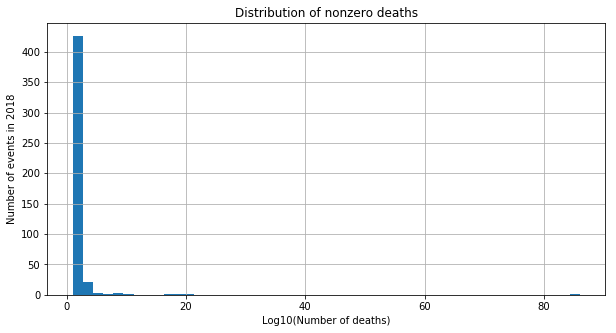

In [72]:
# Number of events with nonzero deaths
fig, ax = plt.subplots(figsize=(10,5))
pd.Series([x for x in df2.deaths if x > 0]).hist(bins=50, ax=ax);
ax.set_xlabel('Log10(Number of deaths)')
ax.set_ylabel('Number of events in 2018')
ax.set_title('Distribution of nonzero deaths')
plt.show()

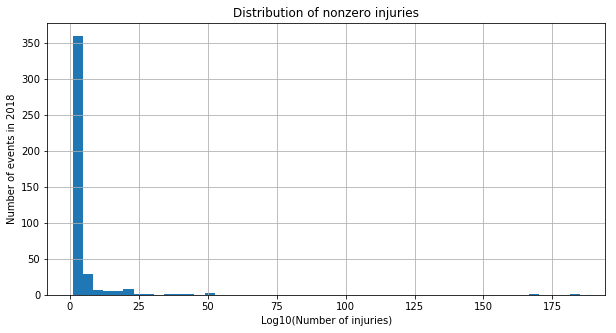

In [76]:
# Number of events with nonzero injuries
fig, ax = plt.subplots(figsize=(10,5))
pd.Series([x for x in df2.injuries if x > 0]).hist(bins=50, ax=ax);
ax.set_xlabel('Log10(Number of injuries)')
ax.set_ylabel('Number of events in 2018')
ax.set_title('Distribution of nonzero injuries')
plt.show()

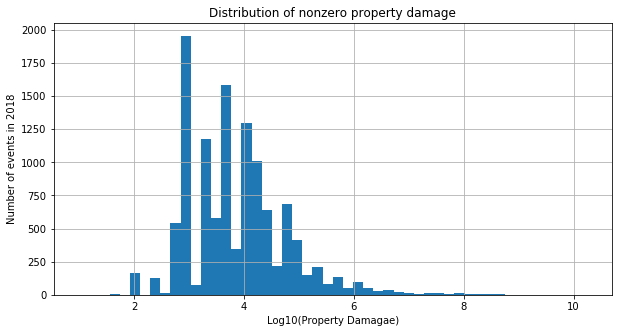

In [73]:
fig, ax = plt.subplots(figsize=(10,5))
pd.Series([np.log10(x) for x in df2.damage if x > 0]).hist(bins=50, ax=ax)
ax.set_xlabel('Log10(Property Damagae)')
ax.set_ylabel('Number of events in 2018')
ax.set_title('Distribution of nonzero property damage')
plt.show()

## NOAA file processing function

In [183]:
def process_noaa(filepath):
    """
    Process one year of NOAA Extreme weather events. Requires
    the list of official counties and the list of official weather
    event types.
    
    Inputs
    ------
    filepath (string) : file path for the CSV data file.
    
    
    Outputs
    -------
    result (pandas.DataFrame) : Dataframe with the list of official FIPS
                                    codes as index and one column for each 
                                    disaster type handled by NOAA.
    
    """
    
    df1 = pd.read_csv(filepath)
    
    # Extract only a few useful columns
    df2 = df1[['STATE','STATE_FIPS','CZ_TYPE','CZ_FIPS',
               'DEATHS_DIRECT','DEATHS_INDIRECT','DAMAGE_PROPERTY',
              'INJURIES_DIRECT', 'INJURIES_INDIRECT']].copy()

    # Turn nulls into zeros
    df2 = df2.fillna(0)

    # Cast STATE_FIPS as int, to make sure it gets processed correctly when it's a string
    df2['STATE_FIPS'] = df2['STATE_FIPS'].astype(int)

    # Add a column with the two-letter state code
    df2['state'] = df2['STATE'].map(state_codes)

    # Aggregate direct + indirect
    df2['deaths'] = df2['DEATHS_DIRECT'] + df2['DEATHS_INDIRECT']
    df2['injuries'] = df2['INJURIES_DIRECT'] + df2['INJURIES_INDIRECT']

    # Property damages are coded as strings with abbreviations for thousands,
    # millions, and billions (why would anyone do that, seriously?). 
    # I'll process them into floats.

    def process_damages(x):
        try:
            if x == 0:
                return 0
            elif len(x) == 1:
                return 0
            elif x[-1] == 'K':
                return float(x[:-1])*1000
            elif x[-1] == 'M':
                return float(x[:-1])*1000000
            elif x[-1] == 'B':
                return float(x[:-1])*1000000000
            else:
                return np.nan
        except:
            print(x)

    df2['damage'] = df2['DAMAGE_PROPERTY'].apply(process_damages)

    # Remove any entries that don't happen in states on the official list
    # (this excludes entries from lakes, oceans, and territories)
    df2 = df2[df2['STATE_FIPS'].isin(state_FIPS_codes.values())]

    # Drop useless columns
    df2 = df2.drop(columns=['DEATHS_DIRECT','DEATHS_INDIRECT',
                            'INJURIES_DIRECT','INJURIES_INDIRECT',
                           'DAMAGE_PROPERTY'])

    # Split the dataframe into county- and zone-level events
    df2_counties = df2[df2.CZ_TYPE == 'C'].copy()
    df2_zones = df2[df2.CZ_TYPE == 'Z'].copy()


    ## Process county-level events
    #------------------------------------------------------------------
    
    # Re-cast FIPS codes as strings
    df2_counties['STATE_FIPS'] = df2_counties['STATE_FIPS'].astype(str)
    df2_counties['CZ_FIPS'] = df2_counties['CZ_FIPS'].astype(str)

    # Make sure the string for CZ_FIPS is 3 digits long.
    FIPS_2 = []
    for fip in df2_counties['CZ_FIPS']:
        if len(fip) == 3:
            fip2 = fip
        elif len(fip) == 2:
            fip2 = '0' + fip
        elif len(fip) == 1:
            fip2 = '00' + fip
        FIPS_2.append(fip2)

    df2_counties['CZ_FIPS'] = FIPS_2

    # Create a full FIPS for each county, cast as int.
    complete_FIPS = [int(x+y) for x, y in zip(df2_counties['STATE_FIPS'],
                                              df2_counties['CZ_FIPS'])]
    df2_counties['FIPS'] = complete_FIPS

    # Get rid of any events for counties not on the official list
    df2_counties = df2_counties[df2_counties.FIPS.isin(official_counties)]

    
    ## Process Zone-level events
    #------------------------------------------------------------------
    
    # Re-cast FIPS codes as strings
    df2_zones['CZ_FIPS'] = df2_zones['CZ_FIPS'].astype(str)

    # Make sure the string for CZ_FIPS is 3 digits long.
    FIPS_2 = []
    for fip in df2_zones['CZ_FIPS']:
        if len(fip) == 3:
            fip2 = fip
        elif len(fip) == 2:
            fip2 = '0' + fip
        elif len(fip) == 1:
            fip2 = '00' + fip
        FIPS_2.append(fip2)

    df2_zones['CZ_FIPS'] = FIPS_2

    # Add the two-letter state code
    df2_zones['Zone_FIPS'] = df2_zones['state'] + df2_zones['CZ_FIPS']

    # Add the full list of county FIPS codes
    df2_zones['FIPS'] = df2_zones['Zone_FIPS'].map(zone_dict)

    # Drop any rows with NANs in FIPS.
    df2_zones = df2_zones.dropna(subset=['FIPS'])
    
    
    # Aggregate zone and county events
    #------------------------------------------------------------------
    
    # In order to aggregate the county- and zone-level events, I'll create
    # a single dictionary of official zipcodes and event types.
    
    all_damages = {}
    for fips in official_counties:
        all_damages[fips] = {x:0 for x in ['deaths','injuries','damage']}

    # Populate the dictionary with a count for each county-level event.
    for row in df2_counties.iterrows():
        fips = row[1]['FIPS']
        all_damages[fips]['deaths'] += row[1]['deaths']
        all_damages[fips]['injuries'] += row[1]['injuries']
        all_damages[fips]['damage'] += row[1]['damage']


    # Populate the dictionary with a count for each zone-level event.
    for row in df2_zones.iterrows():
        # Obtain list of affected counties
        fips = row[1]['FIPS']

        # Divide all damages equally between the counties in the zone
        num_affected = len(fips)
        deaths = row[1]['deaths'] / num_affected
        injuries = row[1]['injuries'] / num_affected
        damage = row[1]['damage'] / num_affected

        for fip in fips:
            all_damages[fip]['deaths'] += deaths
            all_damages[fip]['injuries'] += injuries
            all_damages[fip]['damage'] += damage
    
    # Populate the dictionary with a count for each zone-level event.
    for row in df2_zones.iterrows():
        # Obtain list of affected counties
        fips = row[1]['FIPS']

        # Divide all damages equally between the counties in the zone
        num_affected = len(fips)
        deaths = row[1]['deaths'] / num_affected
        injuries = row[1]['injuries'] / num_affected
        damage = row[1]['damage'] / num_affected

        for fip in fips:
            all_damages[fip]['deaths'] += deaths
            all_damages[fip]['injuries'] += injuries
            all_damages[fip]['damage'] += damage
    
    # Turn the dictionary into a dataframe
    result = pd.DataFrame(all_damages).T
    
    return result

In [184]:
%%time
# Example
test_2018 = process_noaa('../data_local/NOAA/StormEvents_details-ftp_v1.0_d2018_c20190422.csv')
display(test_2018)

(3141, 3)
CPU times: user 12 s, sys: 209 ms, total: 12.3 s
Wall time: 12.6 s


# Process all the available data

In [185]:
import glob
import os

# Read the CSV files for each year going back to 1996 (the first year 
# when many of these event types started being recorded)
path = '../data_local/NOAA/'
filenames = sorted(glob.glob(os.path.join(path, '*.csv')))
years = []
layers = []

# Aggregate the dataframes in a list
for name in filenames:
    year = int(name[49:53])
    print(f'Processing {year}')
    years.append(year)
    layers.append(process_noaa(name))

# Concatenate all these dataframes into a single multi-layer dataframe
noaa = pd.concat(layers, keys=years)

Processing 1996
Processing 1997
Processing 1998
Processing 1999
Processing 2000
Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006


/anaconda3/envs/sand2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018


In [186]:
display(noaa)

(72243, 3)


damage  deaths  injuries
1996 1001  121000.0     0.0       0.0
     1003  329000.0     2.0       2.0
     1005   10000.0     0.0       0.0
     1007  115000.0     0.0       0.0
     1009  413000.0     0.0       0.0

# Visualizing the data
In order to get a preview of what the data looks like, I'll aggregate all the years of event counts, take their logarithm (so that outliers don't dominate the map), and combine that with the dataset of county shapes.

In [198]:
# Aggregate data by county (years summed up)
noaa_county = noaa.groupby(level=1).sum()

# Take the log of event numbers, which should display better than the raw
# event counts
noaa_county_log = np.log10(noaa_county+1)

# Reset the index, thus extracting the FIPS codes into their own column
noaa_county_log = noaa_county_log.reset_index()

# Rename that column accordingly
noaa_county_log = noaa_county_log.rename(columns={'index':'FIPS'})

# Merge with the dataframe of county shapes
noaa_county_map_log = counties.merge(noaa_county_log, on='FIPS', how='left')

In [199]:
display(noaa_county_map_log)

(3141, 9)


,FIPS,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,geometry,damage,deaths,injuries
0,1001,Autauga,Alabama,1,1,POLYGON ((-86.82066986329349 32.34730960076057...,7.427942,0.903090,1.986772
1,1003,Baldwin,Alabama,1,3,POLYGON ((-87.97308978075395 31.16482251520438...,7.737876,1.477121,1.763428
2,1005,Barbour,Alabama,1,5,POLYGON ((-85.74337279655801 31.62624052460075...,6.413970,0.000000,1.255273
3,1007,Bibb,Alabama,1,7,POLYGON ((-87.41985563876936 33.01177307648309...,7.229778,0.301030,1.322219
4,1009,Blount,Alabama,1,9,POLYGON ((-86.96799449037186 33.86045466926403...,7.520844,0.301030,1.778151


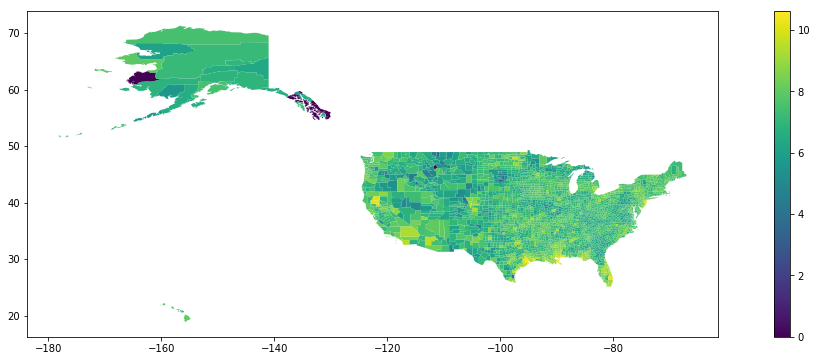

In [200]:
noaa_county_map_log.plot(column='damage', figsize=(20,6), legend=True);

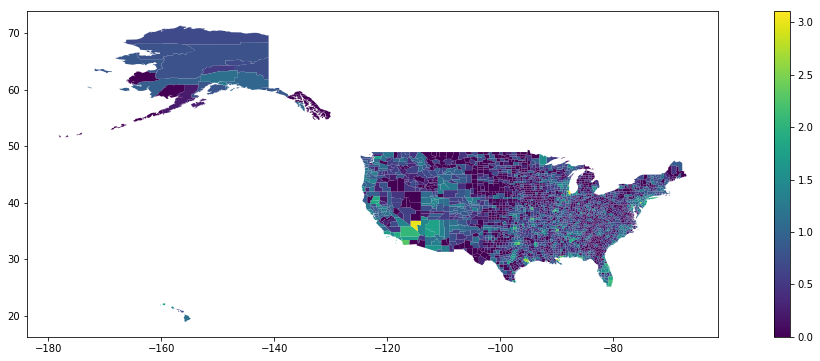

In [201]:
noaa_county_map_log.plot(column='deaths', figsize=(20,6), legend=True);

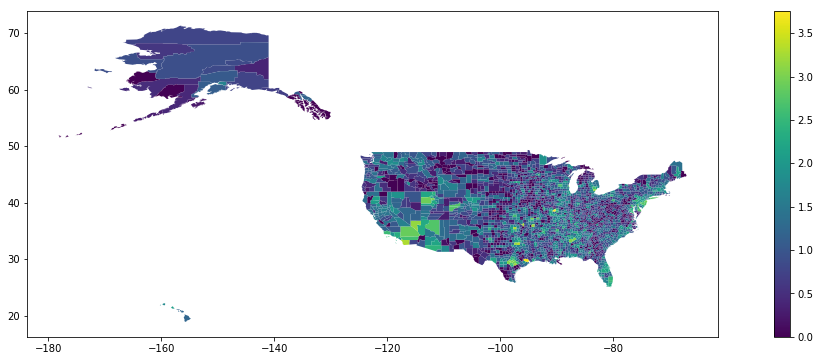

In [202]:
noaa_county_map_log.plot(column='injuries', figsize=(20,6), legend=True);

# Export

In [210]:
# Export to CSV, so it can be added to our database
noaa_county.to_csv('../data_output/5__NOAA/damages_by_county.csv', index_label=['FIPS'])

In [207]:
# Export to geoJSON file
noaa_county_map_log.to_file("../data_output/5__NOAA/damages_by_county.geojson",
                     driver='GeoJSON')